In [1]:
import torch
import numpy as np

Environment closely follows OpenAI gym API. Currently can not be invoked with ```gym.make("env_id")```, though it should be easy to do.

In [2]:
from env import Env

env = Env()

In [3]:
import monte_carlo_tree

def state_to_board(state):
    board = np.zeros((3, 8, 8))
    for piece in state['pieces']:
        if piece['color'] == "Black":
            board[0, piece['x'], piece['y']] = 1
        else: 
            board[1, piece['x'], piece['y']] = 1
        board[2] = 1 if state['turn']['color'] == "Black" else 0

    return board


class CheckersNode(monte_carlo_tree.Node):
    """Go Game Tree Node"""

    def whites(self):
        """White pieces on board"""
        return state_to_board(self.state)[1]
    
    def blacks(self):
        """Black pieces on board"""
        return state_to_board(self.state)[0]

    def get_piece_by_id(self, piece_id):
        pieces = list(
            filter(
                lambda p: p['id'] == piece_id, 
                self.state['pieces']
            )
        )

        if len(pieces) > 0:
            return pieces[0]

        return None

    def get_piece_by_coord(self, x, y):
        pieces =  list(
            filter(lambda p: p['x'] == x and p['y'] == y, 
                self.state['pieces']
            )
        )

        if len(pieces) > 0:
            return pieces[0]

        return None

    def current_player(self):
        """Return 1 if current player plays black, and -1 for whites"""
        return 1 if self.state['turn']['color'] == 'Black' else -1
    
    def possible_actions(self, player=None):
        """List of possible next actions"""
        player = self.current_player()

        coords = []
        for piece_id in range(0, 24):
            piece = self.get_piece_by_id(piece_id)

            if piece is None: continue
            if player == 0 and piece['color'] == "Black": continue
            if player == 1 and piece['color'] == "White": continue
                
            for action in self.state['moveset'][piece_id]:
                coords.append((piece['x'], piece['y'], action[0], action[1]))

        actions = np.zeros((8, 8, 8, 8))
        for c in coords: 
            actions[c] = 1
        return actions

    def possible_actions_list(self):
        actions = self.possible_actions()
        return np.argwhere(actions==1)

    def evaluate(self, env):
        return self.reward

    def prepare_action(self, action):
        return {
            'piece': self.get_piece_by_coord(action[0], action[1]),
            'square': {'x': int(action[2]), 'y': int(action[3])}
        }
    def prepare_state(self, player=None):
        if player == None: player = self.current_player()  
        state = self.blacks() - self.whites() if player == 1 else self.whites() - self.blacks()
        if player == 1: state = np.flip(state, 1)
        return state.copy()

## Random Play Tree

This is very basic algorithm that plays the game by making random moves. Sometimes it reaches the end goal, but overall it supper inneficient.

In [4]:
BOARD_SIZE = 8

rt = monte_carlo_tree.RandomPlayTree(env, CheckersNode, BOARD_SIZE)


def random_play():
    '''
    Play a game using random tree strategy
    '''
    return rt.simulate(rt.root_node)
    

def build_stats(playfunc, n_games=100):
    '''
    Play a number of random games and display result
    '''

    black_wins = 0
    white_wins = 0
    draws = 0
    moves = []
    
    for _ in range(n_games):
        m = playfunc()

        reward = m.reward

        if reward > 0:
            black_wins += 1
        elif reward < 0:
            white_wins += 1
        elif reward == 0.0:
            draws += 1
       
        moves.append(m.depth())
    
    print("Blacks: ", black_wins, "Whites: ", white_wins, "Draws: ", draws, "Moves mean:", np.mean(moves))

In [5]:
# build_stats(random_play, 100)

## Monte Carlo Search Tree

In [6]:
mcst = monte_carlo_tree.MonteCarloPlayTree(env, CheckersNode, BOARD_SIZE)

def mtsc_play():
    '''
    Play a game using MonteCarloSearchTree
    '''
    
    return mcst.simulate(mcst.root_node)

In [7]:
# build_stats(mtsc_play, 100)

## Alpha Zero

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class ActorCritic(nn.Module):

    def __init__(self, board_size=BOARD_SIZE):
        super(ActorCritic, self).__init__()
        
        self.board_size = board_size
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.layer1 = nn.Linear(256, 4096)
        self.layer2 = nn.Linear(256, 1)
        
    def forward(self, x):

        x = x.unsqueeze(1)

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2)
        x = F.dropout(x, p=0.2, training=self.training)
        x = x.view(-1, 256)
        
        prob = F.softmax(self.layer1(x), dim=0).view(-1, 8, 8, 8, 8)
        value = torch.tanh(self.layer2(x))

        return prob, value.view(-1, 1)

actor_critic_network = ActorCritic().to(device)

In [9]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F


# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# class ActorCritic(nn.Module):

#     def __init__(self, board_size=BOARD_SIZE):
#         super(ActorCritic, self).__init__()
        
#         self.board_size = board_size
#         self.conv1 = nn.Conv2d(1, 128, kernel_size=3, padding=1)
#         self.conv2 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
#         self.conv3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
#         self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
#         self.layer1 = nn.Linear(512, 4096)
#         self.layer2 = nn.Linear(512, 1)
        
#     def forward(self, x):

#         x = x.unsqueeze(1)

#         x = F.relu(self.conv1(x))
#         x = F.relu(self.conv2(x))
#         x = F.max_pool2d(x, 2)
#         x = F.relu(self.conv3(x))
#         x = F.max_pool2d(x, 2)
#         x = F.relu(self.conv4(x))
#         x = F.max_pool2d(x, 2)
#         x = F.dropout(x, p=0.2, training=self.training)
#         x = x.view(-1, 512)
        
#         prob = F.softmax(self.layer1(x), dim=0).view(-1, 8, 8, 8, 8)
#         value = F.hardtanh(self.layer2(x))

#         return prob, value.view(-1, 1)

# actor_critic_network = ActorCritic().to(device)

In [10]:
losses = []

In [11]:
actor_critic_network.load_state_dict(torch.load("./checkers.pt"))
for _ in range(20):
    azt = monte_carlo_tree.GuidedMonteCarloPlayTree(env, CheckersNode, BOARD_SIZE, actor_critic_network, device)
    for loss in azt.train(100):
        losses.append(loss)
        torch.save(actor_critic_network.state_dict(), "./checkers.pt")

Loss total: tensor(1864.8966, device='cuda:0', grad_fn=<SumBackward0>) score:  -1 player:  1
Loss total: tensor(1453.9934, device='cuda:0', grad_fn=<SumBackward0>) score:  1 player:  1
Loss total: tensor(1616.0759, device='cuda:0', grad_fn=<SumBackward0>) score:  -1 player:  1
Loss total: tensor(1584.4651, device='cuda:0', grad_fn=<SumBackward0>) score:  -1 player:  1
Loss total: tensor(2163.0107, device='cuda:0', grad_fn=<SumBackward0>) score:  -1 player:  1
Loss total: tensor(1667.6860, device='cuda:0', grad_fn=<SumBackward0>) score:  1 player:  1
Loss total: tensor(486.6496, device='cuda:0', grad_fn=<SumBackward0>) score:  0 player:  1
Loss total: tensor(1456.5037, device='cuda:0', grad_fn=<SumBackward0>) score:  1 player:  1
Loss total: tensor(1997.5409, device='cuda:0', grad_fn=<SumBackward0>) score:  -1 player:  1
Loss total: tensor(1448.9390, device='cuda:0', grad_fn=<SumBackward0>) score:  1 player:  1
Loss total: tensor(1894.2463, device='cuda:0', grad_fn=<SumBackward0>) score

KeyboardInterrupt: 

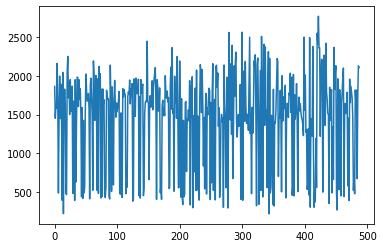

In [12]:
%matplotlib inline

from matplotlib import pyplot as plt 
plt.plot([l.detach().cpu().numpy() for l in losses])
plt.show()